In [5]:
from dolfin import *
from fenics import *
from IPython.lib.display import Audio
from IPython.display import clear_output
from mshr import *
from scipy import fft
import mshr
import math
import numpy as np
import matplotlib.pyplot as plt
import random
framerate = 4410
play_time_seconds = 1

### Generating Subdomain

This creates the circle that will be the nucleator of the cell

In [9]:
class Circle(SubDomain):
    def inside(self, x, on_boundary):
        return pow(x[0] - .5, 2) + pow(x[1] - .5, 2) <= pow(radius, 2)

### Generating Mesh

A 16 dimensional FunctionSpace is too computational heavy to be realized. A Vector Function Space was used instead to speed up the process. To further mimic the biophysical space of the cell, a closed boundary condition was used.

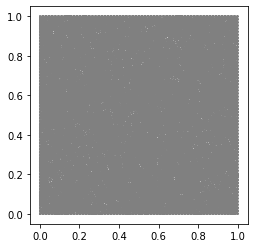

In [10]:
radius = 0.125 
domain = Rectangle(Point(0.0, 0.0), Point(1., 1.))
domain.set_subdomain(1, mshr.Circle(Point(.5, .5), radius))
mesh = generate_mesh(domain, 64)
plot(mesh)
A = VectorFunctionSpace(mesh, 'Lagrange', 1, dim = 16)
circle = Circle()

## Splitting the Function Space

We split the function space into individual solvable parts, with each representing a different protein and the previous and next time steps

In [11]:
# Define functions
u_new = Function(A)  # solution for the next step
u_old  = Function(A)  # solution from previous step
u_new.rename("fields","")

# Split mixed functions
c1_new, c2_new, c3_new, c4_new, c5_new, c6_new, c7_new, c8_new, mu1_new , mu2_new , mu3_new, mu4_new, mu5_new, mu6_new, mu7_new, mu8_new = split(u_new)
c1_old, c2_old, c3_old, c4_old, c5_old, c6_old, c7_old, c8_old, mu1_old , mu2_old , mu3_old, mu4_old, mu5_old, mu6_old, mu7_old, mu8_old = split(u_old)

# Define test functions
tf = TestFunction(A)
q_1, q_2, q_3, q_4, q_5, q_6, q_7, q_8, v_1, v_2, v_3, v_4, v_5, v_6, v_7, v_8 = split(tf)

### Determining the Concentrations

Taking values from Lee et. al. (2003) in nM. Designating a Cytoplasm percentage, and converting each component to a percentage of the cell

In [12]:
Cytoplasm_Concentration = 0.875 
GSK_Axin_Total = 4.83*10e-3      
Axin_Concentraion = 9.66*10e-4*.25       
GSK_Concentration = GSK_Axin_Total - Axin_Concentraion 
UP_BCAT = 0.10
CK1_Concentration = GSK_Concentration * 1.10

#### Conversion to percentages

In [13]:
Intial_Protein_Concentration = np.array([Axin_Concentraion ,GSK_Concentration, UP_BCAT, CK1_Concentration])                                       
Final_Sum = (sum(Intial_Protein_Concentration)*(Cytoplasm_Concentration )/(1-Cytoplasm_Concentration ))                          
Concentrations = np.array([Intial_Protein_Concentration[0], Intial_Protein_Concentration[1], 
                           Intial_Protein_Concentration[2], Intial_Protein_Concentration[3], 
                           Final_Sum ])
Conc_Percentage = Concentrations/sum(Concentrations)

Nuc_V_Control = 15.0 #Strength of the nucleator. Didn't want to define some arbitrary number.

Nucleator_Volume = Conc_Percentage[1] * Nuc_V_Control #Multiply the concentration percentage of GSK
noise = Conc_Percentage*0.1 #Defining the noise of the system for initialization (when the homogenous field is created)

#### Printing Pentages of each component
The total concentraion MUST ALWAYS be ONE!

In [14]:
print('Inital Concentration:',Intial_Protein_Concentration)
print('Concentration with Cyto', Conc_Percentage)
print('Concentration plus Noise', Conc_Percentage + noise*(0.5 - random.random()))
print('Noise', noise)
print('Total Concentration:',sum(Conc_Percentage))

Inital Concentration: [ 0.002415   0.045885   0.1        0.0504735]
Concentration with Cyto [ 0.00151869  0.02885508  0.06288565  0.03174059  0.875     ]
Concentration plus Noise [ 0.00151259  0.02873914  0.06263298  0.03161306  0.87148443]
Noise [ 0.00015187  0.00288551  0.00628856  0.00317406  0.0875    ]
Total Concentration: 1.0


### Defining the Initial Values

In [ ]:
class InitialConditions(UserExpression):
    def __init__(self, **kwargs):
        random.seed(42)
        super().__init__(**kwargs)
    #First half will be the initial concentrations of various molecules
    #Have it set to have some sort of perturbation
    #Second half is chemical potential mu
    def eval(self, values, x):
        #C1: APC/Axin
        values[0] = Conc_Percentage[0] + noise[0]*(0.5 - random.random())
        #C2: Destruction Complex Proteins
        values[1] = Conc_Percentage[1] + noise[1]*(0.5 - random.random())
        #C3: CK 1
        values[2] = Conc_Percentage[3] + noise[3]*(0.5 - random.random())
        #C4: Unphosphorylated B-Cat
        values[3] = Conc_Percentage[2]  + noise[2]*(0.5 - random.random())
        #C5: Ck-1 phosphorylated B-Cat
        values[4] = 0.0
        #C6: CK1 + GSK phosphorylated B-Cat
        values[5] = 0.0
        #C7: Cytoplasm
        values[6] = Conc_Percentage[4] + noise[4]*(0.5 - random.random())
        #C8: Centriole
        values[7] = 0.0
        
        #Energy Values for each component.
        values[8] = 0.0
        values[9] = 0.0 
        values[10] = 0.0
        values[11] = 0.0
        values[12] = 0.0
        values[13] = 0.0
        values[14] = 0.0
        values[15] = 0.0
        #Creating the Nucleator
        if circle.inside(x, True):
            #values[2] = conc_perc[3]
            values[7] = Nucleator_Volume
    def value_shape(self):
        return (16,)

### Inserting Values Into Function Space

In [ ]:
# Create intial conditions and interpolate
u_init = InitialConditions(degree=1)
#Injecting the inital conditions into the vector function space
u_new.interpolate(u_init)
u_old.interpolate(u_init)

### Creating the Free Energy Equation and Finding the Derivative to generate $\mu$

In [ ]:
c1_new = variable(c1_new)
c2_new = variable(c2_new)
c3_new = variable(c3_new)
c4_new = variable(c4_new)
c5_new = variable(c5_new)
c6_new = variable(c6_new)
c7_new = variable(c7_new)
c8_new = variable(c8_new)

def int_calc(chi_Axin_GSK, chi_Axin_CK1, chi_Axin_UPBC, chi_Axin_PBC, chi_Axin_pPBC, chi_Axin_Cyto, chi_Axin_Nuc, 
             chi_GSK_CK1, chi_GSK_UPBC, chi_GSK_PBC, chi_GSK_pPBC, chi_GSK_Cyto, chi_GSK_Nuc,
             chi_CK1_UPBC, chi_CK1_PBC, chi_CK1_pPBC, chi_CK1_Cyto, chi_CK1_Nuc,
             chi_UPBC_PBC, chi_UPBC_pPBC, chi_UPBC_Cyto, chi_UPBC_Nuc,
             chi_PBC_pPBC, chi_PBC_Cyto, chi_PBC_Nuc,
             chi_pPBC_Cyto, chi_pPBC_Nuc,
             Chi_Cyto_Nuc):
    
# Compute the chemical potential df/dc

    f1  = chi_Axin_GSK*  (c1_new**2*c2_new**2)    
    f2  = chi_Axin_CK1*  (c1_new**2*c3_new**2)      
    f3  = chi_Axin_UPBC* (c1_new**2*c4_new**2)    
    f4  = chi_Axin_PBC*  (c1_new**2*c5_new**2)  
    f5  = chi_Axin_pPBC* (c1_new**2*c6_new**2)     
    f6  = chi_Axin_Cyto* (c1_new**2*c7_new**2) 
    f7  = chi_Axin_Nuc*  (c1_new**2*c8_new**2) 

    f8  = chi_GSK_CK1*   (c2_new**2*c3_new**2)       
    f9  = chi_GSK_UPBC*  (c2_new**2*c4_new**2)  
    f10 = chi_GSK_PBC*   (c2_new**2*c5_new**2) 
    f11 = chi_GSK_pPBC*  (c2_new**2*c6_new**2) 
    f12 = chi_GSK_Cyto*  (c2_new**2*c7_new**2) 
    f13 = chi_GSK_Nuc*   (c2_new**2*c8_new**2)  

    f14 = chi_CK1_UPBC*  (c3_new**2*c4_new**2)    
    f15 = chi_CK1_PBC*   (c3_new**2*c5_new**2)     
    f16 = chi_CK1_pPBC*  (c3_new**2*c6_new**2)     
    f17 = chi_CK1_Cyto*  (c3_new**2*c7_new**2) 
    f18 = chi_CK1_Nuc*   (c3_new**2*c8_new**2) 

    f19 = chi_UPBC_PBC*  (c4_new**2*c5_new**2)    
    f20 = chi_UPBC_pPBC* (c4_new**2*c6_new**2)   
    f21 = chi_UPBC_Cyto* (c4_new**2*c7_new**2)     
    f22 = chi_UPBC_Nuc*  (c4_new**2*c8_new**2) 

    f23 = chi_PBC_pPBC*  (c5_new**2*c6_new**2)
    f24 = chi_PBC_Cyto*  (c5_new**2*c7_new**2)     
    f25 = chi_PBC_Nuc*   (c5_new**2*c8_new**2) 

    f26 = chi_pPBC_Cyto* (c6_new**2*c7_new**2)   
    f27 = chi_pPBC_Nuc*  (c6_new**2*c8_new**2) 

    f28 = Chi_Cyto_Nuc*  (c7_new**2*c8_new**2) 
    
    
    ft  = (f1 + f2 + f3 + f4 + f5 + f6 + f7 + 
           f8 + f9 + f10 + f11 + f12 + f13 +
           f14 + f15 +f16 + f17 + f18 + 
           f19 + f20 + f21 + f22 + 
           f23 + f24 + f25 + 
           f26 + f27 + 
           f28) 
    
    dfdc1p = diff(ft, c1_new)
    dfdc2p = diff(ft, c2_new)
    dfdc3p = diff(ft, c3_new)
    dfdc4p = diff(ft, c4_new)
    dfdc5p = diff(ft, c5_new)
    dfdc6p = diff(ft, c6_new)
    dfdc7p = diff(ft, c7_new)
    dfdc8p = diff(ft, c8_new)
    return(dfdc1p, dfdc2p, dfdc3p, dfdc4p, dfdc5p, dfdc6p, dfdc7p, dfdc8p)

### Defining the Weak Form of the Cahn Hilliard

In [ ]:
def form_Res(dfdc1p, dfdc2p, dfdc3p, dfdc4p, dfdc5p, dfdc6p, dfdc7p , dfdc8p , nucleator_diffusion):
    lmbda  = 5.0e-6 
    dt     = 5.0e-5 
    theta  = 0.5
    mu1_mid = (1.0-theta)*mu1_old + theta*mu1_new
    mu2_mid = (1.0-theta)*mu2_old + theta*mu2_new
    mu3_mid = (1.0-theta)*mu3_old + theta*mu3_new
    mu4_mid = (1.0-theta)*mu4_old + theta*mu4_new
    mu5_mid = (1.0-theta)*mu5_old + theta*mu5_new
    mu6_mid = (1.0-theta)*mu6_old + theta*mu6_new
    mu7_mid = (1.0-theta)*mu7_old + theta*mu7_new
    mu8_mid = (1.0-theta)*mu8_old + theta*mu8_new
    
#Nucleator
    Res_1 = (c1_new - c1_old)/dt*q_1*dx + dot(grad(mu1_mid), grad(q_1) )*dx
#Destruction Complex
    Res_2 = (c2_new - c2_old)/dt*q_2*dx + dot(grad(mu2_mid), grad(q_2) )*dx
#CK
    Res_3 = (c3_new - c3_old)/dt*q_3*dx + dot(grad(mu3_mid), grad(q_3) )*dx 
#UPBCAT
    Res_4 = (c4_new - c4_old)/dt*q_4*dx + dot(grad(mu4_mid), grad(q_4) )*dx +  10*c3_new*c4_new*q_4*dx
#CPBC
    Res_5 = (c5_new - c5_old)/dt*q_5*dx + dot(grad(mu5_mid), grad(q_5) )*dx -  10*c3_new*c4_new*q_5*dx + 10*c2_new*c5_new*q_5*dx 
#GCBC
    Res_6 = (c6_new - c6_old)/dt*q_6*dx + dot(grad(mu6_mid), grad(q_6) )*dx -  10*c2_new*c5_new*q_6*dx
#Cyto
    Res_7 = (c7_new - c7_old)/dt*q_7*dx + dot(grad(mu7_mid), grad(q_7) )*dx
#Centriole
    Res_8 = (c8_new - c8_old)/dt*q_8*dx + nucleator_diffusion* 0.001* dot(grad(mu8_mid), grad(q_8) )*dx
#Energy
    Res_9  = mu1_new*v_1*dx - (dfdc1p*v_1*dx) - lmbda*(dot(grad(c1_new), grad(v_1)) + dot(grad(c2_new), grad(v_2)) + dot(grad(c3_new), grad(v_3)) + dot(grad(c4_new), grad(v_4)) + dot(grad(c5_new), grad(v_5)) + dot(grad(c6_new), grad(v_6))+ dot(grad(c7_new), grad(v_7))+ dot(grad(c8_new), grad(v_8)))*dx
    Res_10 = mu2_new*v_2*dx - (dfdc2p*v_2*dx) - lmbda*(dot(grad(c1_new), grad(v_1)) + dot(grad(c2_new), grad(v_2)) + dot(grad(c3_new), grad(v_3)) + dot(grad(c4_new), grad(v_4)) + dot(grad(c5_new), grad(v_5)) + dot(grad(c6_new), grad(v_6))+ dot(grad(c7_new), grad(v_7))+ dot(grad(c8_new), grad(v_8)))*dx
    Res_11 = mu3_new*v_3*dx - (dfdc3p*v_3*dx) - lmbda*(dot(grad(c1_new), grad(v_1)) + dot(grad(c2_new), grad(v_2)) + dot(grad(c3_new), grad(v_3)) + dot(grad(c4_new), grad(v_4)) + dot(grad(c5_new), grad(v_5)) + dot(grad(c6_new), grad(v_6))+ dot(grad(c7_new), grad(v_7))+ dot(grad(c8_new), grad(v_8)))*dx
    Res_12 = mu4_new*v_4*dx - (dfdc4p*v_4*dx) - lmbda*(dot(grad(c1_new), grad(v_1)) + dot(grad(c2_new), grad(v_2)) + dot(grad(c3_new), grad(v_3)) + dot(grad(c4_new), grad(v_4)) + dot(grad(c5_new), grad(v_5)) + dot(grad(c6_new), grad(v_6))+ dot(grad(c7_new), grad(v_7))+ dot(grad(c8_new), grad(v_8)))*dx
    Res_13 = mu5_new*v_5*dx - (dfdc5p*v_5*dx) - lmbda*(dot(grad(c1_new), grad(v_1)) + dot(grad(c2_new), grad(v_2)) + dot(grad(c3_new), grad(v_3)) + dot(grad(c4_new), grad(v_4)) + dot(grad(c5_new), grad(v_5)) + dot(grad(c6_new), grad(v_6))+ dot(grad(c7_new), grad(v_7))+ dot(grad(c8_new), grad(v_8)))*dx
    Res_14 = mu6_new*v_6*dx - (dfdc6p*v_6*dx) - lmbda*(dot(grad(c1_new), grad(v_1)) + dot(grad(c2_new), grad(v_2)) + dot(grad(c3_new), grad(v_3)) + dot(grad(c4_new), grad(v_4)) + dot(grad(c5_new), grad(v_5)) + dot(grad(c6_new), grad(v_6))+ dot(grad(c7_new), grad(v_7))+ dot(grad(c8_new), grad(v_8)))*dx
    Res_15 = mu7_new*v_7*dx - (dfdc7p*v_7*dx) - lmbda*(dot(grad(c1_new), grad(v_1)) + dot(grad(c2_new), grad(v_2)) + dot(grad(c3_new), grad(v_3)) + dot(grad(c4_new), grad(v_4)) + dot(grad(c5_new), grad(v_5)) + dot(grad(c6_new), grad(v_6))+ dot(grad(c7_new), grad(v_7))+ dot(grad(c8_new), grad(v_8)))*dx
    Res_16 = mu8_new*v_8*dx - (dfdc8p*v_8*dx) - lmbda*(dot(grad(c1_new), grad(v_1)) + dot(grad(c2_new), grad(v_2)) + dot(grad(c3_new), grad(v_3)) + dot(grad(c4_new), grad(v_4)) + dot(grad(c5_new), grad(v_5)) + dot(grad(c6_new), grad(v_6))+ dot(grad(c7_new), grad(v_7))+ dot(grad(c8_new), grad(v_8)))*dx
    
    ResT =  Res_1 + Res_2  + Res_3 + Res_4 + Res_5 + Res_6 + Res_7 + Res_8 + Res_9 + Res_10 + Res_11 + Res_12 + Res_13 + Res_14 + Res_15 + Res_16
    
    return (ResT)


### Location of Output Files

In [ ]:
# Output files for concentration and chemical potential
#Push to a cloud.
fileC1 = File("SimData/(5_18)/Nucleator No Axin/(5)1.pvd", "compressed")
fileC2 = File("SimData/(5_18)/Nucleator No Axin/(5)2.pvd", "compressed")
fileC3 = File("SimData/(5_18)/Nucleator No Axin/(5)3.pvd", "compressed")
fileC4 = File("SimData/(5_18)/Nucleator No Axin/(5)4.pvd", "compressed")
fileC5 = File("SimData/(5_18)/Nucleator No Axin/(5)5.pvd", "compressed")
fileC6 = File("SimData/(5_18)/Nucleator No Axin/(5)6.pvd", "compressed")
fileC7 = File("SimData/(5_18)/Nucleator No Axin/(5)7.pvd", "compressed")
fileC8 = File("SimData/(5_18)/Nucleator No Axin/(5)8.pvd", "compressed")
fileM1 = File("SimData/(5_18)/Nucleator No Axin/chem_potential1.pvd", "compressed")
fileM2 = File("SimData/(5_18)/Nucleator No Axin/chem_potential2.pvd", "compressed")
fileM3 = File("SimData/(5_18)/Nucleator No Axin/chem_potential3.pvd", "compressed")
fileM4 = File("SimData/(5_18)/Nucleator No Axin/chem_potential4.pvd", "compressed")
fileM5 = File("SimData/(5_18)/Nucleator No Axin/chem_potential5.pvd", "compressed")
fileM6 = File("SimData/(5_18)/Nucleator No Axin/chem_potential6.pvd", "compressed")
fileM7 = File("SimData/(5_18)/Nucleator No Axin/chem_potential7.pvd", "compressed")
fileM8 = File("SimData/(5_18)/Nucleator No Axin/chem_potential8.pvd", "compressed")

### Generating the log scaled values for the three interaction behaviors

In [ ]:
#Input the distance between each behavior, has to be float
scale_distance = 1.0
#Create pre-logged behavior array
pre_10 = np.array([-scale_distance, 0, scale_distance])
#Create new behavior
behaviors = 10 ** pre_10
print(behaviors)
binding = behaviors[0]
neutral = behaviors[1]
seperating = behaviors[2]

#Printing Behaviors
chi_array = np.array([binding,  neutral, seperating])
log_check = np.log10(chi_array)
print(chi_array)
print(log_check)

### Setting Behaviors for each interaction

In [ ]:
nsteps = 750

chi_Axin_GSK  = binding  
chi_Axin_CK1  = binding     
chi_Axin_UPBC = binding     
chi_Axin_PBC  = binding    
chi_Axin_pPBC = seperating     
chi_Axin_Cyto = seperating
chi_Axin_Nuc  = binding 

chi_GSK_CK1   = neutral      
chi_GSK_UPBC  = neutral    
chi_GSK_PBC   = neutral     
chi_GSK_pPBC  = seperating 
chi_GSK_Cyto  = neutral 
chi_GSK_Nuc   = neutral

chi_CK1_UPBC  = neutral     
chi_CK1_PBC   = neutral
chi_CK1_pPBC  = seperating  
chi_CK1_Cyto  = neutral 
chi_CK1_Nuc   = binding

chi_UPBC_PBC  = neutral  
chi_UPBC_pPBC = seperating     
chi_UPBC_Cyto = neutral
chi_UPBC_Nuc  = neutral

chi_PBC_pPBC  = seperating
chi_PBC_Cyto  = neutral    
chi_PBC_Nuc   = neutral

chi_pPBC_Cyto = binding
chi_pPBC_Nuc  = seperating

Chi_Cyto_Nuc  = seperating

nucleator_diffusion = 1



### Calling the Newtown solver for predefined number of steps and generating the Data

In [ ]:
dfdc1p, dfdc2p, dfdc3p, dfdc4p, dfdc5p, dfdc6p, dfdc7p, dfdc8p = int_calc(chi_Axin_GSK, chi_Axin_CK1, chi_Axin_UPBC, chi_Axin_PBC, chi_Axin_pPBC, chi_Axin_Cyto, chi_Axin_Nuc, 
             chi_GSK_CK1, chi_GSK_UPBC, chi_GSK_PBC, chi_GSK_pPBC, chi_GSK_Cyto, chi_GSK_Nuc,
             chi_CK1_UPBC, chi_CK1_PBC, chi_CK1_pPBC, chi_CK1_Cyto, chi_CK1_Nuc,
             chi_UPBC_PBC, chi_UPBC_pPBC, chi_UPBC_Cyto, chi_UPBC_Nuc,
             chi_PBC_pPBC, chi_PBC_Cyto, chi_PBC_Nuc,
             chi_pPBC_Cyto, chi_pPBC_Nuc,
             Chi_Cyto_Nuc)

ResT = form_Res(dfdc1p, dfdc2p, dfdc3p, dfdc4p, dfdc5p, dfdc6p, dfdc7p, dfdc8p, nucleator_diffusion)
try:
    for i in range(nsteps):
        dfdc1p, dfdc2p, dfdc3p, dfdc4p, dfdc5p, dfdc6p, dfdc7p, dfdc8p = int_calc(chi_Axin_GSK, chi_Axin_CK1, chi_Axin_UPBC, chi_Axin_PBC, chi_Axin_pPBC, chi_Axin_Cyto, chi_Axin_Nuc, 
             chi_GSK_CK1, chi_GSK_UPBC, chi_GSK_PBC, chi_GSK_pPBC, chi_GSK_Cyto, chi_GSK_Nuc,
             chi_CK1_UPBC, chi_CK1_PBC, chi_CK1_pPBC, chi_CK1_Cyto, chi_CK1_Nuc,
             chi_UPBC_PBC, chi_UPBC_pPBC, chi_UPBC_Cyto, chi_UPBC_Nuc,
             chi_PBC_pPBC, chi_PBC_Cyto, chi_PBC_Nuc,
             chi_pPBC_Cyto, chi_pPBC_Nuc,
             Chi_Cyto_Nuc)
        ResT = form_Res(dfdc1p, dfdc2p, dfdc3p, dfdc4p, dfdc5p, dfdc6p, dfdc7p, dfdc8p, nucleator_diffusion)
        clear_output(wait = True)
        print(i)
        u_old.vector()[:] = u_new.vector()
        solve(ResT == 0, u_new)
        valuesf = u_new.vector()
        fileC1 << (u_new.split()[0], i)
        fileC2 << (u_new.split()[1], i)
        fileC3 << (u_new.split()[2], i)
        fileC4 << (u_new.split()[3], i)
        fileC5 << (u_new.split()[4], i)
        fileC6 << (u_new.split()[5], i)
        fileC7 << (u_new.split()[6], i)
        fileC8 << (u_new.split()[7], i)
        
        fileM1 << (u_new.split()[8], i)
        fileM2 << (u_new.split()[9], i)
        fileM3 << (u_new.split()[10], i)
        fileM4 << (u_new.split()[11], i)
        fileM5 << (u_new.split()[12], i)
        fileM6 << (u_new.split()[13], i)
        fileM7 << (u_new.split()[14], i)
        fileM8 << (u_new.split()[15], i)
    
except Exception as e:
    print(e)
    t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
    audio_data = np.sin(2*np.pi*300*t) + np.sin(2*np.pi*240*t)
    Audio(audio_data, rate=framerate, autoplay=True)
    print("Convergence Error")
